In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

import torch_geometric
print(torch_geometric.__version__)

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.7 MB/s eta 0:00:00
2.5.3


In [ ]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import pandas as pd
import json
import numpy as np
import torch
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import negative_sampling

# Load the edges
edges_df = pd.read_csv('/content/drive/MyDrive/musae_facebook_edges.csv')

# Load the node features
with open('/content/drive/MyDrive/musae_facebook_features.json', 'r') as f:
    features_json = json.load(f)

# Find the maximum number of features to set feature size
max_features_len = max(len(features) for features in features_json.values())

# Assuming that the JSON keys are the string representations of the node IDs
node_features = np.zeros((max(max(map(int, features_json.keys())), max(edges_df.max())) + 1, max_features_len))

# Populate the feature matrix with features from the JSON file
for node_id, features in features_json.items():
    node_features[int(node_id), :len(features)] = features

# Normalize features
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)
node_features_tensor = torch.tensor(node_features, dtype=torch.float)

# Create a NetworkX graph
G = nx.Graph()
G.add_edges_from(edges_df.values)

# Prepare the positive edge index
edge_index_np = edges_df.to_numpy().T
edge_index_tensor = torch.tensor(edge_index_np, dtype=torch.long)

# Generate negative samples
neg_edge_index_tensor = negative_sampling(
    edge_index=edge_index_tensor,
    num_nodes=node_features_tensor.size(0),
    num_neg_samples=edge_index_tensor.size(1),
)

# Filter out any negative edges that do exist in the graph
filtered_neg_edge_index = []
for u, v in neg_edge_index_tensor.t().tolist():
    if not G.has_edge(u, v):
        filtered_neg_edge_index.append([u, v])

# If we didn't get enough negative samples, resample
while len(filtered_neg_edge_index) < edge_index_tensor.size(1):
    extra_neg_edge_index = negative_sampling(
        edge_index=edge_index_tensor,
        num_nodes=node_features_tensor.size(0),
        num_neg_samples=edge_index_tensor.size(1) - len(filtered_neg_edge_index),
    )
    for u, v in extra_neg_edge_index.t().tolist():
        if not G.has_edge(u, v) and [u, v] not in filtered_neg_edge_index:
            filtered_neg_edge_index.append([u, v])

filtered_neg_edge_index = torch.tensor(filtered_neg_edge_index, dtype=torch.long).t()

# Splitting the data into training and test sets
# This should be done before filtering negative samples, based on your edge_index_tensor

# Use your own criteria or method to create train_mask and test_mask
train_mask, test_mask = train_test_split(range(edge_index_tensor.size(1)), test_size=0.15, random_state=42)

train_pos_edge_index = edge_index_tensor[:, train_mask]
test_pos_edge_index = edge_index_tensor[:, test_mask]

# Here, you will also need to split your negative edges if you're planning to evaluate on them
train_neg_edge_index = filtered_neg_edge_index[:, train_mask]
test_neg_edge_index = filtered_neg_edge_index[:, test_mask]


In [ ]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GATConv, BatchNorm, LayerNorm, GraphSAGE, GAE

from torch_geometric.nn import SAGEConv

class EnhancedGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EnhancedGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)  # GAT layer
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels, aggr='mean')  # GraphSAGE layer
        self.bn3 = BatchNorm(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)  # Final GCN layer
        self.bn4 = BatchNorm(out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.bn4(self.conv4(x, edge_index))  # No activation before the final layer
        return x

# Initialize model
encoder = EnhancedGCN(in_channels=node_features_tensor.size(1), hidden_channels=64, out_channels=64)
model = GAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)




In [ ]:
from sklearn.metrics import roc_auc_score
def compute_scores_and_loss(pos_edge_index, neg_edge_index, node_embeddings):
    pos_scores = torch.sigmoid((node_embeddings[pos_edge_index[0]] * node_embeddings[pos_edge_index[1]]).sum(dim=1))
    neg_scores = torch.sigmoid((node_embeddings[neg_edge_index[0]] * node_embeddings[neg_edge_index[1]]).sum(dim=1))


    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))])

    loss = -torch.log(pos_scores + 1e-8).mean() - torch.log(1 - neg_scores + 1e-8).mean()
    return scores.detach().cpu().numpy(), labels.detach().cpu().numpy(), loss


    # Combine scores and true labels
    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))])

    # Calculate loss
    loss = -torch.log(pos_scores + 1e-8).mean() - torch.log(1 - neg_scores + 1e-8).mean()
    return scores.detach().cpu().numpy(), labels.detach().cpu().numpy(), loss

# Initialize lists to store the metrics for plotting
losses = []
auc_scores = []
learning_rates = []

# Training loop
for epoch in range(610):
    model.train()
    optimizer.zero_grad()
    node_embeddings = model(node_features_tensor, edge_index_tensor)
    scores, labels, loss = compute_scores_and_loss(train_pos_edge_index, train_neg_edge_index, node_embeddings)

    loss.backward()
    optimizer.step()

    # Calculate AUC
    train_auc = roc_auc_score(labels, scores)

      # Record the loss, AUC, and current learning rate
    losses.append(loss.item())
    auc_scores.append(train_auc)
    learning_rates.append(optimizer.param_groups[0]['lr'])  # Assuming a single parameter group
    # Extract the exact loss value as a float
    exact_loss_value = loss.item()
    if epoch % 10 == 0:
         # Print loss and AUC
         print(f'Epoch {epoch}: Loss = {exact_loss_value:.7f}, Train AUC = {train_auc:.4f}')

Epoch 0: Loss = 0.8688950, Train AUC = 0.9599
Epoch 10: Loss = 0.8723224, Train AUC = 0.9579
Epoch 20: Loss = 0.8703351, Train AUC = 0.9590
Epoch 30: Loss = 0.8677377, Train AUC = 0.9595
Epoch 40: Loss = 0.8684918, Train AUC = 0.9597
Epoch 50: Loss = 0.8682821, Train AUC = 0.9605
Epoch 60: Loss = 0.8668554, Train AUC = 0.9604
Epoch 70: Loss = 0.8695091, Train AUC = 0.9600
Epoch 80: Loss = 0.8694913, Train AUC = 0.9596
Epoch 90: Loss = 0.8654442, Train AUC = 0.9609
Epoch 100: Loss = 0.8642009, Train AUC = 0.9613
Epoch 110: Loss = 0.8637180, Train AUC = 0.9612
Epoch 120: Loss = 0.8676694, Train AUC = 0.9600
Epoch 130: Loss = 0.8631284, Train AUC = 0.9616
Epoch 140: Loss = 0.8671064, Train AUC = 0.9608
Epoch 150: Loss = 0.8666890, Train AUC = 0.9614
Epoch 160: Loss = 0.8664405, Train AUC = 0.9604
Epoch 170: Loss = 0.8685498, Train AUC = 0.9610
Epoch 180: Loss = 0.8680470, Train AUC = 0.9599
Epoch 190: Loss = 0.8677924, Train AUC = 0.9604
Epoch 200: Loss = 0.8670560, Train AUC = 0.9604
Epo

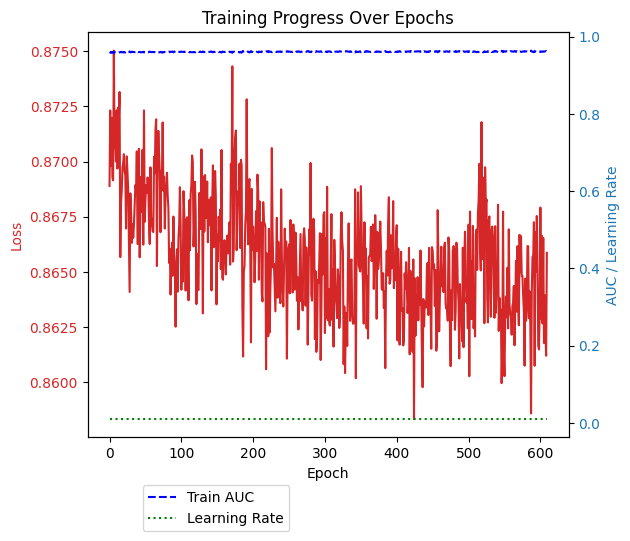

In [ ]:
import matplotlib.pyplot as plt
# Plotting
fig, ax1 = plt.subplots()

# Loss (left y-axis)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(610), losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for AUC and learning rate
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('AUC / Learning Rate', color=color)
ax2.plot(range(610), auc_scores, color='blue', linestyle='dashed', label='Train AUC')
ax2.plot(range(610), learning_rates, color='green', linestyle='dotted', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Progress Over Epochs')
plt.legend(loc='upper left', bbox_to_anchor=(0.1, -0.1))
plt.show()


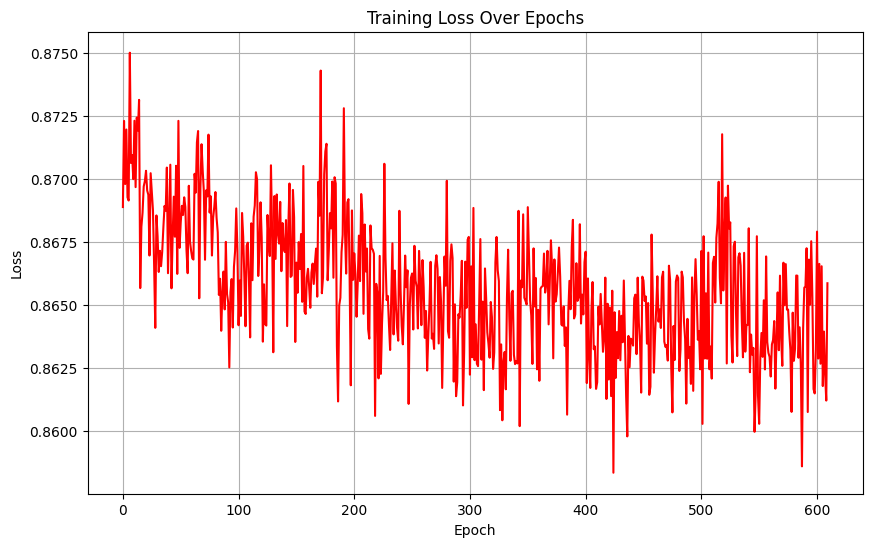

In [ ]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(610), losses, color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


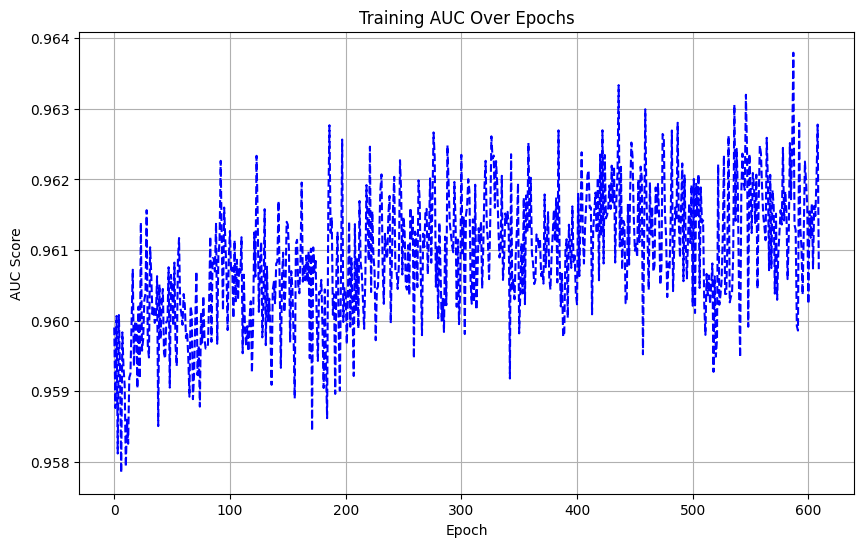

In [ ]:
# Plot Training AUC
plt.figure(figsize=(10, 6))
plt.plot(range(610), auc_scores, color='blue', linestyle='dashed')
plt.title('Training AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.grid(True)
plt.show()


In [ ]:
    def get_predictions(node_embeddings, edge_index, threshold=0.6736):
        # Calculate scores using the sigmoid function to interpret them as probabilities
        scores = torch.sigmoid((node_embeddings[edge_index[0]] * node_embeddings[edge_index[1]]).sum(dim=1))
        # Convert scores to binary predictions based on the threshold
        predictions = (scores > threshold).int()
        return predictions


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
  import matplotlib.pyplot as plt
  import seaborn as sns

  def plot_confusion_matrix(cm, class_names):
      """
      Plots a confusion matrix using seaborn's heatmap.

      Args:
      cm (array): The confusion matrix to be plotted.
      class_names (list): The names of the classes.
      """
      plt.figure(figsize=(10, 7))
      sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
      plt.xlabel('Predicted labels')
      plt.ylabel('True labels')
      plt.title('Confusion Matrix')
      plt.show()


Best threshold: 0.6736 with 2427 false positives


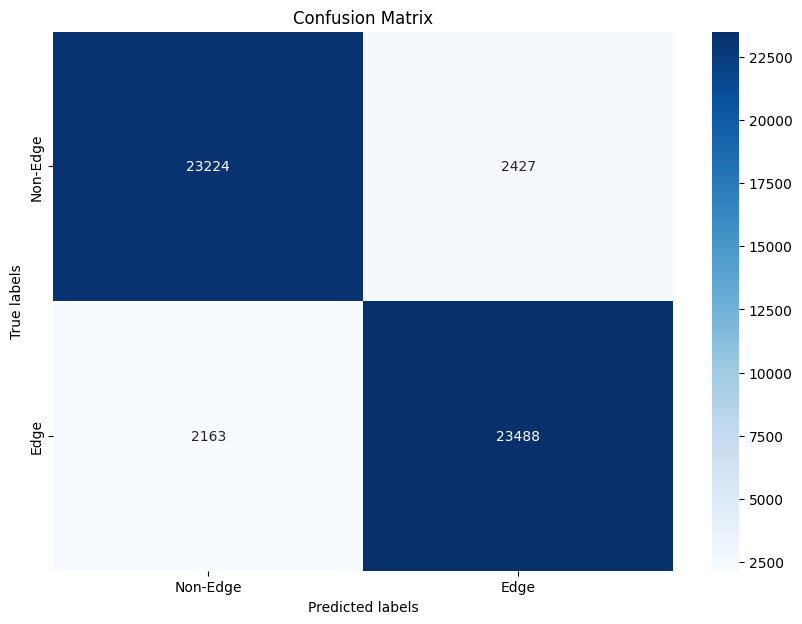

In [ ]:
# Model evaluation mode
model.eval()

# Disable gradient computation for performance
with torch.no_grad():
    # Generate node embeddings
    node_embeddings = model(node_features_tensor, edge_index_tensor)

    # Get predictions for positive test edges
    test_pos_predictions = get_predictions(node_embeddings, test_pos_edge_index)

    # Get predictions for negative test edges
    test_neg_predictions = get_predictions(node_embeddings, test_neg_edge_index)

    # Combine positive and negative predictions
    test_predictions = torch.cat([test_pos_predictions, test_neg_predictions], dim=0)

    # Assuming test_labels is already defined: 1s for positive test edges, 0s for negative
    test_labels = torch.cat([torch.ones(test_pos_edge_index.size(1)), torch.zeros(test_neg_edge_index.size(1))])

# Convert tensors to NumPy arrays for sklearn compatibility
test_labels = test_labels.numpy()
test_predictions = test_predictions.numpy()

best_threshold = 0.6736
best_fp = float('inf')
best_conf_matrix = None

for threshold in np.arange(0.6736, 1, 0.6736):
    test_pos_predictions = get_predictions(node_embeddings, test_pos_edge_index)
    test_neg_predictions = get_predictions(node_embeddings, test_neg_edge_index)


    test_predictions = torch.cat([test_pos_predictions, test_neg_predictions], dim=0)
    test_labels = torch.cat([torch.ones(test_pos_edge_index.size(1)), torch.zeros(test_neg_edge_index.size(1))])

    conf_matrix = confusion_matrix(test_labels.numpy(), test_predictions.numpy())
    fp = conf_matrix[0][1]  # False positives are in the off-diagonal of the non-edge row
    if fp < best_fp:
        best_fp = fp
        best_threshold = threshold
        best_conf_matrix = conf_matrix

print(f'Best threshold: {best_threshold} with {best_fp} false positives')

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

plot_confusion_matrix(best_conf_matrix, class_names=['Non-Edge', 'Edge'])



In [ ]:
# Compute the AUC score
test_auc = roc_auc_score(test_labels, test_predictions)

# Print the AUC score
print(f'Test AUC: {test_auc:.4f}')

Test AUC: 0.9104


Best threshold: 0.6736 with F1 Score: 0.9110


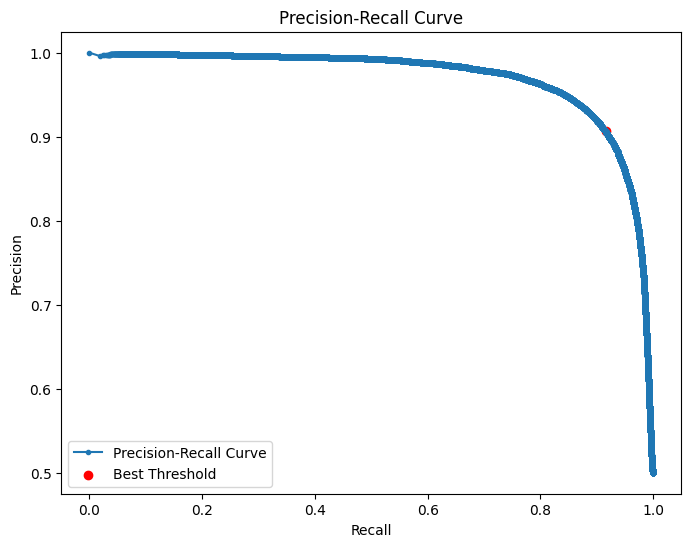

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Generate scores using the sigmoid function
pos_scores = torch.sigmoid((node_embeddings[test_pos_edge_index[0]] * node_embeddings[test_pos_edge_index[1]]).sum(dim=1))
neg_scores = torch.sigmoid((node_embeddings[test_neg_edge_index[0]] * node_embeddings[test_neg_edge_index[1]]).sum(dim=1))

# Concatenate the scores of the positive and negative edges
all_scores = torch.cat([pos_scores, neg_scores], dim=0).numpy()

# All labels: ones for positive edges, zeros for negative edges
all_labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))]).numpy()

# Make sure that all_scores and all_labels are now of the same length
assert len(all_scores) == len(all_labels), "The scores and labels must have the same length"

# Now compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(all_labels, all_scores)

# Compute F1 scores for each threshold
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)  # Adding a small constant to avoid division by zero

# Locate the index of the largest F1 score
best_f1_index = np.argmax(f1_scores[:-1])  # The last value of recall will be 1 and precision will be 0, leading to F1=NaN, so we skip it
best_threshold = thresholds[best_f1_index]

print(f'Best threshold: {best_threshold:.4f} with F1 Score: {f1_scores[best_f1_index]:.4f}')

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.scatter(recall[best_f1_index], precision[best_f1_index], marker='o', color='red', label='Best Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()



In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def get_true_and_predicted_edges(test_pos_edge_index, test_neg_edge_index, node_embeddings, model, threshold=0.6781):
    model.eval()
    with torch.no_grad():
        pos_scores = torch.sigmoid((node_embeddings[test_pos_edge_index[0]] * node_embeddings[test_pos_edge_index[1]]).sum(dim=1))
        neg_scores = torch.sigmoid((node_embeddings[test_neg_edge_index[0]] * node_embeddings[test_neg_edge_index[1]]).sum(dim=1))

        pos_pred = pos_scores > threshold
        neg_pred = neg_scores > threshold

    true_edges = [tuple(edge) for edge in test_pos_edge_index.t().tolist()]
    predicted_edges = [tuple(edge) for edge, pred in zip(test_pos_edge_index.t().tolist(), pos_pred) if pred]
    predicted_edges += [tuple(edge) for edge, pred in zip(test_neg_edge_index.t().tolist(), neg_pred) if pred]

    print("Predicted Edges (Positive Predictions):", [tuple(edge) for edge, pred in zip(test_pos_edge_index.t().tolist(), pos_pred) if pred])
    print("Predicted Edges (Negative Predictions):", [tuple(edge) for edge, pred in zip(test_neg_edge_index.t().tolist(), neg_pred) if pred])

    return true_edges, predicted_edges


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
edges_df = pd.read_csv('/content/drive/MyDrive/musae_facebook_edges.csv')
G = nx.from_pandas_edgelist(edges_df, 'id_1', 'id_2')

def visualize_test_edges_with_names(node_id, G, test_pos_edge_index, node_embeddings, model, threshold=0.5, node_name_map=None):
    if node_id not in G:
        print(f"Node {node_id} does not exist in the graph.")
        return

    # Model to evaluate the test edges
    model.eval()
    with torch.no_grad():
        scores = torch.sigmoid((node_embeddings[test_pos_edge_index[0]] * node_embeddings[test_pos_edge_index[1]]).sum(dim=1))
        predictions = scores > threshold
        predicted_edges = test_pos_edge_index[:, predictions].t().numpy()

    # Create subgraph with neighbors
    neighbors = list(G.neighbors(node_id))
    sub_nodes = set([node_id] + neighbors)
    sub_G = G.subgraph(sub_nodes)

    # Position nodes for visualization
    pos = nx.spring_layout(sub_G)

    # Get actual edges for these nodes
    actual_edges = [(u, v) for u, v in G.edges(sub_nodes) if u in sub_nodes and v in sub_nodes]
    true_positive_edges = [(int(u), int(v)) for u, v in predicted_edges if u in sub_nodes and v in sub_nodes and G.has_edge(u, v)]

    # Draw nodes and actual edges
    nx.draw_networkx_nodes(sub_G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_edges(sub_G, pos, edgelist=actual_edges, edge_color='green', style='solid')

    # Highlight true positive edges in red
    nx.draw_networkx_edges(sub_G, pos, edgelist=true_positive_edges, edge_color='red', style='solid')

    # Draw labels with names
    labels = {n: node_name_map.get(n, n) for n in sub_G.nodes()}  # Use node names if available, else node IDs
    nx.draw_networkx_labels(sub_G, pos, labels=labels)

    plt.title(f"Subgraph around Node {node_name_map.get(node_id, node_id)} with Actual and True Positive Links")
    plt.show()

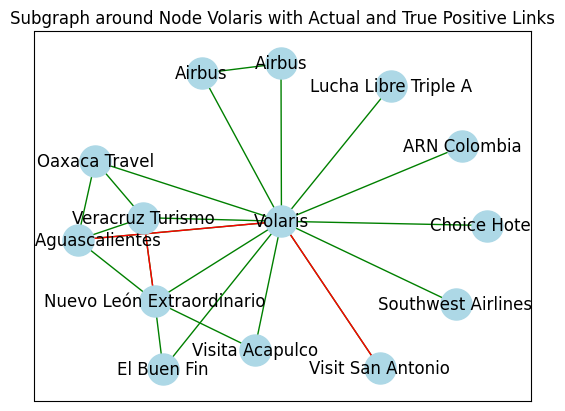

In [ ]:
node_id = 45  # Or any node you are interested in
visualize_test_edges_with_names(node_id, G, test_pos_edge_index, node_embeddings, model, node_name_map=node_name_map)

In [ ]:
import pandas as pd

# Load the target data that contains the node names
node_names_df = pd.read_csv('/content/drive/MyDrive/musae_facebook_target.csv')

# Create a dictionary to map node IDs to their corresponding names
node_name_map = node_names_df.set_index('id')['page_name'].to_dict()


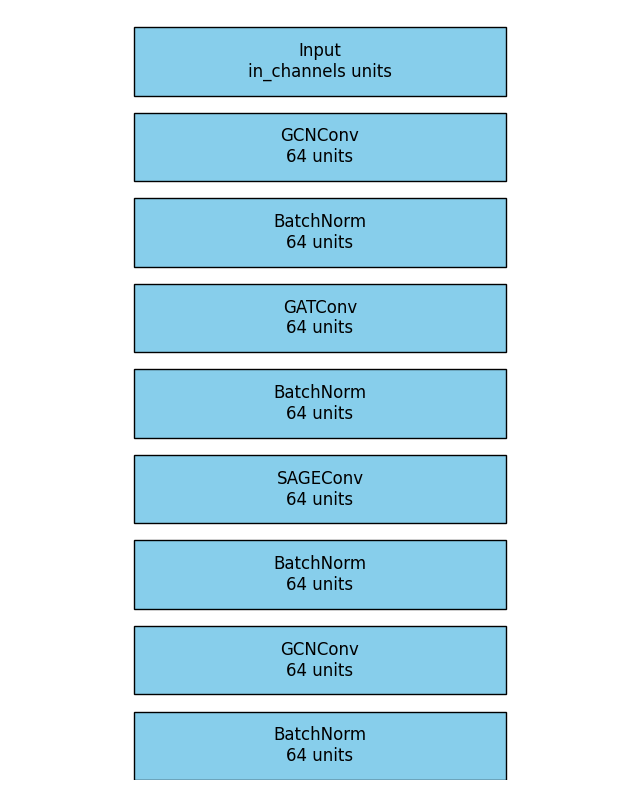

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_model(layers, ax):
    ax.set_xlim(0, 10)
    ax.set_ylim(0, len(layers) * 2.5)
    ax.axis('off')

    for i, (layer_type, units) in enumerate(reversed(layers)):
        y = i * 2.5
        ax.add_patch(patches.Rectangle((2, y), 6, 2, edgecolor='black', facecolor='skyblue'))
        ax.text(5, y + 1, f'{layer_type}\n{units} units', size=12, va='center', ha='center')

fig, ax = plt.subplots(figsize=(8, 10))
layers = [
    ("Input", "in_channels"),
    ("GCNConv", "64"),
    ("BatchNorm", "64"),
    ("GATConv", "64"),
    ("BatchNorm", "64"),
    ("SAGEConv", "64"),
    ("BatchNorm", "64"),
    ("GCNConv", "64"),
    ("BatchNorm", "64")
]
draw_model(layers, ax)
plt.show()


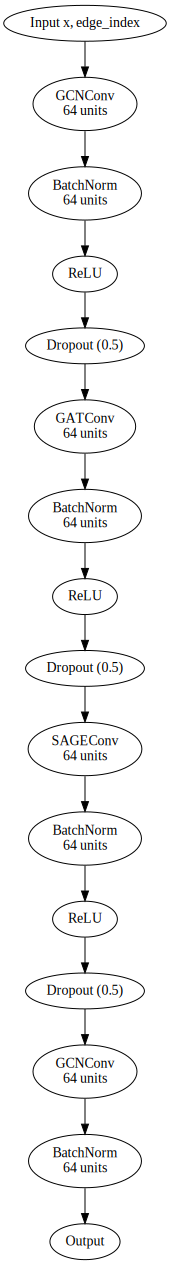

In [ ]:
from graphviz import Digraph

dot = Digraph()

# Adding nodes for each layer and operation
dot.node('Input', 'Input x, edge_index')
dot.node('GCN1', 'GCNConv\n64 units')
dot.node('BN1', 'BatchNorm\n64 units')
dot.node('Relu1', 'ReLU')
dot.node('Drop1', 'Dropout (0.5)')
dot.node('GAT1', 'GATConv\n64 units')
dot.node('BN2', 'BatchNorm\n64 units')
dot.node('Relu2', 'ReLU')
dot.node('Drop2', 'Dropout (0.5)')
dot.node('SAGE1', 'SAGEConv\n64 units')
dot.node('BN3', 'BatchNorm\n64 units')
dot.node('Relu3', 'ReLU')
dot.node('Drop3', 'Dropout (0.5)')
dot.node('GCN2', 'GCNConv\n64 units')
dot.node('BN4', 'BatchNorm\n64 units')
dot.node('Output', 'Output')

# Adding edges according to the forward method
dot.edge('Input', 'GCN1')
dot.edge('GCN1', 'BN1')
dot.edge('BN1', 'Relu1')
dot.edge('Relu1', 'Drop1')
dot.edge('Drop1', 'GAT1')
dot.edge('GAT1', 'BN2')
dot.edge('BN2', 'Relu2')
dot.edge('Relu2', 'Drop2')
dot.edge('Drop2', 'SAGE1')
dot.edge('SAGE1', 'BN3')
dot.edge('BN3', 'Relu3')
dot.edge('Relu3', 'Drop3')
dot.edge('Drop3', 'GCN2')
dot.edge('GCN2', 'BN4')
dot.edge('BN4', 'Output')

# Render the graph to a file and then display it
dot.render('forward_method', format='png', cleanup=True)
dot
